In [13]:
# import importance liberies 
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps, ImageEnhance
import os
import cv2
import plotly.express as px
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
from numpy.linalg import norm
import os
from tqdm import tqdm
import joblib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import joblib 
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import norm

Check out my kaggle notebook of fashion recommendation system on my kaggle account link 
* [kaggle-notebook recommendation using pca and kmeans](https://www.kaggle.com/code/shreyashchacharkar/recommendation-system-using-pca-and-kmeans/notebook)

# Prepare data

In [52]:
DATASET_PATH = "../input/fashion-product-images-small/myntradataset"
df = pd.read_csv(DATASET_PATH+"/styles.csv", usecols=['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage'])
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual


In [55]:
df['image'] = df.apply(lambda row:str(row['id'])+".jpg",axis = 1).reset_index(drop = True)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,53759.jpg


In [ ]:
def load_images(folder_path, img_count=None, target_height=80, target_width=60):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (target_width, target_height))
        images.append(img)
    return np.array(images)

def preprocess_data(images):
    num_images, height, width, channel = images.shape
    flattened_data = images.reshape((num_images, height * width * channel))
    mean_vals = np.mean(flattened_data, axis=0)
    centered_data = flattened_data - mean_vals
    return centered_data, mean_vals, flattened_data

In [ ]:
img_data = load_images("/kaggle/input/fashion-product-images-small/images")

In [ ]:
centered_data, mean_vals, flattened_data = preprocess_data(img_data)

# Model Build

In [11]:
model1 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
model1.trainable = False

model1 = tensorflow.keras.Sequential([
    model1,
    GlobalMaxPooling2D()
])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
None


In [15]:
img_width,img_height,_ = 224,224,3
model_2 = VGG16(weights = 'imagenet',
                   include_top = False,
                   input_shape = (img_width,img_height,3))
model_2.trainable = False

# Adding Embedding Layer
model_2 = tensorflow.keras.models.Sequential([model_2,GlobalMaxPooling2D()])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_max_pooling2d_1 (Gl  (None, 512)               0         
 obalMaxPooling2D)                                               
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


## Model build with PCA
### **Transformation of data into PCA components**

**Why 200 principal components in this case ?**

We already expalined in kaggle notebook(Recommendation_System_using_pca_and_kMeans.ipynb) how 186 principal components represents 90% of data

In [ ]:
%%time
num_components = 200  # Adjust as needed
pca = PCA(n_components=num_components)
lower_dimensional_data = pca.fit_transform(centered_data)

In [16]:
# if don't want to run above cell can take output from previous version of this file
pca = joblib.load("/kaggle/input/pca-data-of-fashion-product/pca_.pkl")
mean_vals = joblib.load("/kaggle/input/pca-data-of-fashion-product/mean_vals_.pkl")

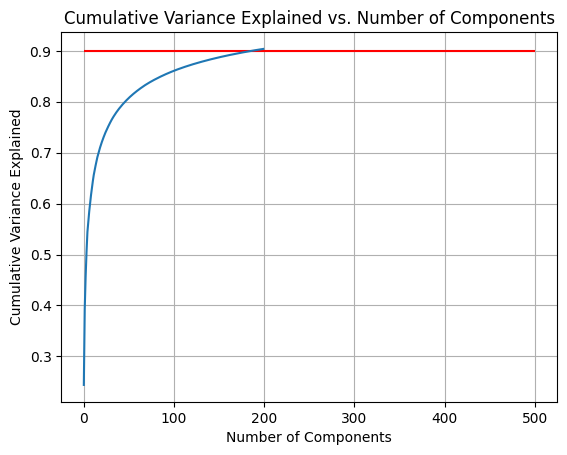

PCA found 90% of data in 186 components


In [17]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
threshold = cumulative_variance[cumulative_variance <= 0.9]
plt.hlines(y=[0.9],xmin=[0],xmax=[500], colors=["red"])
plt.plot(cumulative_variance)
plt.title('Cumulative Variance Explained vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()
print(f"PCA found 90% of data in {len(threshold)} components")

In [ ]:
# import joblib 
# joblib.dump(pca, "pca_.pkl")
# joblib.dump(mean_vals, "mean_vals_.pkl")

#### Comparison between  orginal image and pca recontructed image

In [ ]:
recon_data = pca.inverse_transform(lower_dimensional_data)

In [ ]:
def comparison(idx):
    original = img_data[idx]
    reconstruct_img = recon_data[idx].reshape(80,60,3)
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Plot the first chart (Cumulative Variance)
    axes[0].imshow(original)
    axes[0].set_title('Original Image')

    # Plot the second chart (Individual Variances)
    axes[1].imshow(reconstruct_img)
    axes[1].set_title('Recontructed Image')
    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

In [ ]:
comparison(11325)

**Can checkout analysis with PCA in notebook**  [kaggle-notebook recommendation using pca and kmeans](https://www.kaggle.com/code/shreyashchacharkar/recommendation-system-using-pca-and-kmeans/notebook)

In [ ]:
filenames=[]
path_name = "/kaggle/input/fashion-product-images-small/images"
for file in os.listdir(path_name):
    filenames.append(os.path.join(path_name,file))

feature_list = []

for file in tqdm(filenames):
    feature_list.append(extract_features(file,model))
pickle.dump(feature_list,open('embeddings.pkl','wb'))
pickle.dump(filenames,open('filenames.pkl','wb'))

**OR run below cell you will get feature_list and filenames**

In [18]:
pca = joblib.load("/kaggle/input/pca-data-of-fashion-product/pca_.pkl")
mean_vals = joblib.load("/kaggle/input/pca-data-of-fashion-product/mean_vals_.pkl")
filenames = joblib.load("/kaggle/input/pca-data-of-fashion-product/filenames.pkl")
feature_list = joblib.load("/kaggle/input/pca-data-of-fashion-product/embeddings.pkl")

In [ ]:
neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean',)
neighbors.fit(feature_list)
features = extract_features("/kaggle/input/fashion-product-images-small/images/10010.jpg",model)
distances, indices = neighbors.kneighbors([features])

In [ ]:
def recommend(features,feature_list):
    neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
    neighbors.fit(feature_list)
    distances, indices = neighbors.kneighbors([features])
    return indices

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
count = 0
for i in range(0,5):
    if count == 5:
        break
    else:
        img_ot = filenames[indices[0][count]]
        img_ot = cv2.imread(img_ot)
        axes[count].imshow(img_ot) 
    count += 1
plt.tight_layout()

In [ ]:
np.array(feature_list).shape

In [44]:
def extract_features(img_path,model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (80,60))
    img = img.flatten() - mean_vals
    embeded_img = pca.transform([img])
    recon_img = pca.inverse_transform(embeded_img)[0].reshape(80,60,3)
    img1 = cv2.resize(recon_img, (224,224))
    expanded_img_array = np.expand_dims(img1,axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)
    return normalized_result

def recommend(features,feature_list):
    neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
    neighbors.fit(feature_list)
    distances, indices = neighbors.kneighbors([features])
    print("Recommendation")
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
    count = 0
    for i in range(0,5):
        if count == 5:
            break
        else:
            img_ot = filenames[indices[0][count]]
            img_ot = cv2.imread(img_ot)
            axes[count].imshow(img_ot) 
        count += 1
    plt.tight_layout()

1/1 [==============================] - 0s 56ms/step
Recommendation


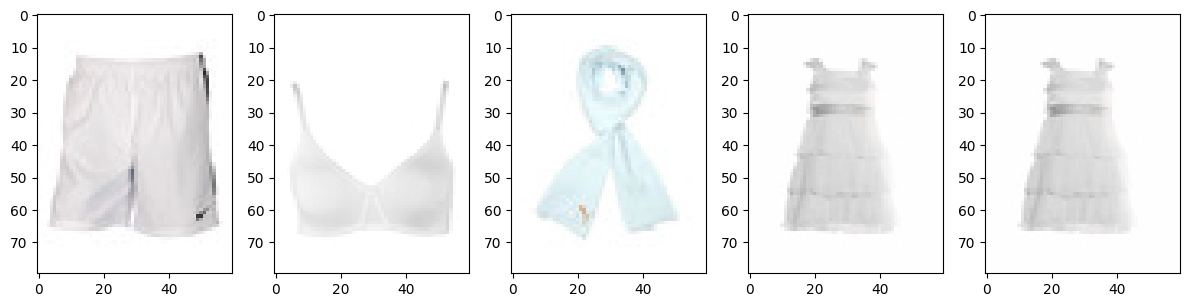

In [45]:
imag_path = "/kaggle/input/fashion-product-images-small/images/10021.jpg"
features= extract_features(imag_path, model1)
recommendation = recommend(features, feature_list)

## Model without PCA

In [42]:
def feature_extraction(img_path,model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)
    return normalized_result

def recommend(features,feature_list):
    neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
    neighbors.fit(feature_list)
    distances, indices = neighbors.kneighbors([features])
    print("Recommendation")
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
    count = 0
    for i in range(0,5):
        if count == 5:
            break
        else:
            img_ot = filenames[indices[0][count]]
            img_ot = cv2.imread(img_ot)
            axes[count].imshow(img_ot) 
        count += 1
    plt.tight_layout()

1/1 [==============================] - 0s 49ms/step
Recommendation


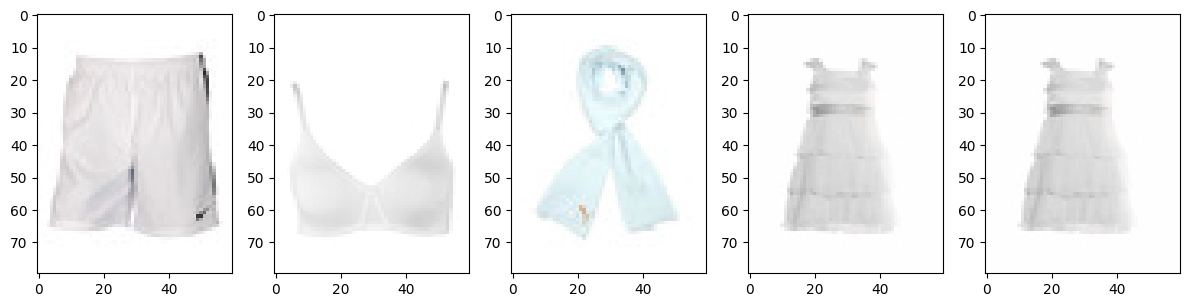

In [47]:
imag_path = "/kaggle/input/fashion-product-images-small/images/10021.jpg"
features= extract_features(imag_path, model1)
recommendation = recommend(features, feature_list)

# Evaluation

### cosine similarity 

In [50]:
df_embeds = pd.DataFrame(data=feature_list)

In [51]:
from sklearn.metrics.pairwise import pairwise_distances

cosine_sim = 1-pairwise_distances(df_embeds, metric='cosine')
cosine_sim[:4, :4]

array([[0.9999992 , 0.7479236 , 0.7979149 , 0.8809422 ],
       [0.7479236 , 0.99999994, 0.7495731 , 0.79932195],
       [0.7979149 , 0.7495731 , 1.        , 0.8406806 ],
       [0.8809422 , 0.79932195, 0.8406806 , 1.        ]], dtype=float32)

In [56]:
def get_recommendations(indices,cosine_sim,index,df,top_n = 5):
    sim_index = indices[index]
    sim_scores = list(enumerate(cosine_sim[sim_index]))
    sim_scores = sorted(sim_scores,key = lambda x:x[1],reverse = True)
    sim_scores = sim_scores[1:top_n+1]
    index_rec = [i[0] for i in sim_scores]
    index_sim = [i[1] for i in sim_scores]
    return indices.iloc[index_rec].index,index_sim

In [58]:
cosine_sim = 1-pairwise_distances(df_embeds, metric='cosine')
indices = pd.Series(range(len(df)),index = df.index)
mean_sim_scores = []
complete_indices = []
complete_scores = []
for index in range(100):    
    try:
        index,sim_array = get_recommendations(indices,cosine_sim,index,df,top_n = 5)
        mean_score = np.mean(sim_array)
        mean_sim_scores.append(mean_score)
        complete_indices.append(index)
        complete_scores.append(sim_array)
    except Exception as ex:
        print(f'Following exception : {ex} occured at the index : {index}')

In [ ]:
a = [list(i) for i in complete_indices]
sub_cat = [df['subCategory'].iloc[a[index]].to_list() for index in range(100)]
mast_cat = [df['masterCategory'].iloc[a[index]].to_list() for index in range(100)]
resnet_50 = pd.DataFrame()
resnet_50['id'] = df['id']
resnet_50['recommended_index'] = [list(i) for i in complete_indices]
resnet_50['recommended_scores'] = complete_scores
resnet_50['masterCategory'] = df['masterCategory']
resnet_50['subCategory'] = df['subCategory']
resnet_50['Recommended_master_category'] = mast_cat
resnet_50['Recommended_sub_category'] = sub_cat
resnet_50['mean_recommended_score'] = mean_sim_scores
resnet_50.head(2)

In [ ]:
def getmatch_score(resnet_50,col,col1):
    
    match_list = []
    for index in range(resnet_50.shape[0]):
        try:
            actual_match = resnet_50[col].iloc[index]
            predicted_match = resnet_50[col1].iloc[index]
            count = 0
            for item in predicted_match:
                if item==actual_match:
                    count+=1
            match_list.append((count/5)*100)
        except Exception as ex:
            print(f'Following exception : {ex} occured at index : {index}')
    
    return match_list

resnet_50['Match_Master_Score'] = getmatch_score(resnet_50,'masterCategory','Recommended_master_category')
resnet_50['Match_Sub_Score'] = getmatch_score(resnet_50,'subCategory','Recommended_sub_category')
resnet_50.head(2)

In [ ]:
sn.distplot(resnet_50['mean_recommended_score'])